In [67]:
import pandas as pd
import covidcast
from datetime import date
import matplotlib
import matplotlib.pyplot as plt
import numpy
import math
from keras.models import Sequential
from keras.layers import Dense
from keras.layers import LSTM
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import mean_squared_error

## EDA on number of Deaths

In [193]:
data = covidcast.signal("usa-facts", "deaths_incidence_num", date(2020, 3, 15), date(2020, 12, 10),"state")

In [194]:
data.head()

,geo_value,signal,time_value,issue,lag,value,stderr,sample_size,geo_type,data_source
0,ak,deaths_incidence_num,2020-03-15,2020-07-09,116,0.0,None,None,state,usa-facts
1,al,deaths_incidence_num,2020-03-15,2020-07-09,116,0.0,None,None,state,usa-facts
2,ar,deaths_incidence_num,2020-03-15,2020-07-09,116,0.0,None,None,state,usa-facts
3,az,deaths_incidence_num,2020-03-15,2020-07-09,116,0.0,None,None,state,usa-facts
4,ca,deaths_incidence_num,2020-03-15,2020-07-09,116,2.0,None,None,state,usa-facts


In [195]:
def prepare_data_for_deaths(df, state):
    data = df[df['geo_value'] == state]
    data = data[['time_value', 'value']]
    data.dropna()
    data = data.rename(columns={"time_value": "time_value", "value": "deaths"})
    data.set_index('time_value', inplace=True)
    return data

<AxesSubplot:xlabel='time_value'>

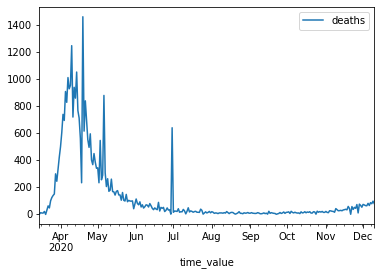

In [196]:
state_deaths_df = prepare_data_for_deaths(data, 'ny')
state_deaths_df.plot()

### Normalize the Dataset

In [197]:
scaler = MinMaxScaler(feature_range=(0, 1))
state_data_deaths = scaler.fit_transform(state_deaths_df)

### Train - Test Split

In [198]:
train_size = int(len(state_data_deaths) * 0.67)
test_size = len(state_data_deaths) - train_size
train, test = state_data_deaths[0:train_size,:], state_data_deaths[train_size:len(state_data_deaths),:]
print(len(train), len(test))

181 90


### Create the dataset

In [214]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [233]:
look_back = 6
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape, trainY.shape)

(174, 6) (174,)


In [230]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

### Run the model using Artifical Neural Networks

In [234]:
model = Sequential()
# model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(256, input_dim=look_back, activation='tanh'))
model.add(Dense(96, activation='tanh'))
model.add(Dense(48, activation='tanh'))
model.add(Dense(28, activation='tanh'))
model.add(Dense(48, activation='tanh'))
model.add(Dense(12, activation='tanh'))
model.add(Dense(6, activation='tanh'))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='sgd')
model.fit(trainX, trainY, epochs=100, batch_size=1, verbose=2)

Epoch 1/100
174/174 - 0s - loss: 0.0156
Epoch 2/100
174/174 - 0s - loss: 0.0125
Epoch 3/100
174/174 - 0s - loss: 0.0111
Epoch 4/100
174/174 - 0s - loss: 0.0107
Epoch 5/100
174/174 - 0s - loss: 0.0100
Epoch 6/100
174/174 - 0s - loss: 0.0101
Epoch 7/100
174/174 - 0s - loss: 0.0094
Epoch 8/100
174/174 - 0s - loss: 0.0099
Epoch 9/100
174/174 - 0s - loss: 0.0091
Epoch 10/100
174/174 - 0s - loss: 0.0100
Epoch 11/100
174/174 - 0s - loss: 0.0092
Epoch 12/100
174/174 - 0s - loss: 0.0097
Epoch 13/100
174/174 - 0s - loss: 0.0095
Epoch 14/100
174/174 - 0s - loss: 0.0088
Epoch 15/100
174/174 - 0s - loss: 0.0088
Epoch 16/100
174/174 - 0s - loss: 0.0092
Epoch 17/100
174/174 - 0s - loss: 0.0093
Epoch 18/100
174/174 - 0s - loss: 0.0091
Epoch 19/100
174/174 - 0s - loss: 0.0091
Epoch 20/100
174/174 - 0s - loss: 0.0094
Epoch 21/100
174/174 - 0s - loss: 0.0094
Epoch 22/100
174/174 - 0s - loss: 0.0090
Epoch 23/100
174/174 - 0s - loss: 0.0092
Epoch 24/100
174/174 - 0s - loss: 0.0089
Epoch 25/100
174/174 - 0s

### Make predictions on the testset

In [235]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 131.18 RMSE
Test Score: 21.84 RMSE


### Visualize the predictions

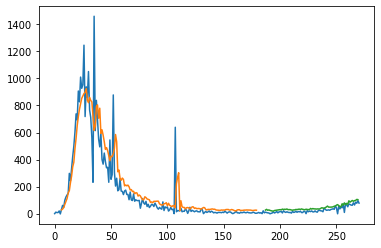

In [236]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(state_data_deaths)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(state_data_deaths)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(state_data_deaths)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(state_data_deaths))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## EDA on number of Cases

In [162]:
cases_data = covidcast.signal("usa-facts", "confirmed_incidence_num", date(2020, 4, 1), date(2020, 12, 10),"state")

In [286]:
def prepare_data_for_cases(df, state):
    data = df[df['geo_value'] == state]
    data = data[['time_value', 'value']]
    data.dropna()
    data = data.rename(columns={"time_value": "time_value", "value": "cases"})
    data.set_index('time_value', inplace=True)
    return data

<AxesSubplot:xlabel='time_value'>

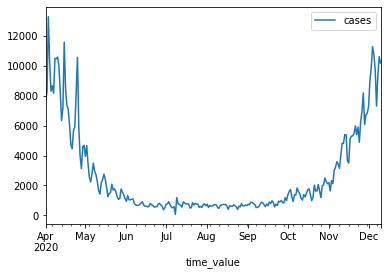

In [287]:
state_cases_df = prepare_data_for_cases(cases_data, 'ny')
state_cases_df.plot()

### Normalize the data

In [288]:
scaler = MinMaxScaler(feature_range=(0, 1))
state_cases = scaler.fit_transform(state_cases_df)

### Split the data into train and test

In [289]:
train_size = int(len(state_cases) * 0.67)
test_size = len(state_cases) - train_size
train, test = state_cases[0:train_size,:], state_cases[train_size:len(state_cases),:]
print(len(train), len(test))

170 84


### Create the Time Series dataset using look_back = 4

In [290]:
def create_dataset(dataset, look_back=1):
    dataX, dataY = [], []
    for i in range(len(dataset)-look_back-1):
        a = dataset[i:(i+look_back), 0]
        dataX.append(a)
        dataY.append(dataset[i + look_back, 0])
    return numpy.array(dataX), numpy.array(dataY)

In [291]:
look_back = 6
trainX, trainY = create_dataset(train, look_back)
testX, testY = create_dataset(test, look_back)
print(trainX.shape, trainY.shape)

(163, 6) (163,)


In [292]:
trainX = numpy.reshape(trainX, (trainX.shape[0], 1, trainX.shape[1]))
testX = numpy.reshape(testX, (testX.shape[0], 1, testX.shape[1]))

### Run the model - LSTM

In [293]:
model = Sequential()
model.add(LSTM(4, input_shape=(1, look_back)))
model.add(Dense(1, activation='relu'))
model.compile(loss='mean_squared_error', optimizer='sgd')
model.fit(trainX, trainY, epochs=200, batch_size=2, verbose=2)

Epoch 1/200
82/82 - 0s - loss: 0.0304
Epoch 2/200
82/82 - 0s - loss: 0.0242
Epoch 3/200
82/82 - 0s - loss: 0.0221
Epoch 4/200
82/82 - 0s - loss: 0.0202
Epoch 5/200
82/82 - 0s - loss: 0.0185
Epoch 6/200
82/82 - 0s - loss: 0.0169
Epoch 7/200
82/82 - 0s - loss: 0.0154
Epoch 8/200
82/82 - 0s - loss: 0.0141
Epoch 9/200
82/82 - 0s - loss: 0.0130
Epoch 10/200
82/82 - 0s - loss: 0.0119
Epoch 11/200
82/82 - 0s - loss: 0.0110
Epoch 12/200
82/82 - 0s - loss: 0.0102
Epoch 13/200
82/82 - 0s - loss: 0.0094
Epoch 14/200
82/82 - 0s - loss: 0.0087
Epoch 15/200
82/82 - 0s - loss: 0.0081
Epoch 16/200
82/82 - 0s - loss: 0.0076
Epoch 17/200
82/82 - 0s - loss: 0.0070
Epoch 18/200
82/82 - 0s - loss: 0.0067
Epoch 19/200
82/82 - 0s - loss: 0.0064
Epoch 20/200
82/82 - 0s - loss: 0.0061
Epoch 21/200
82/82 - 0s - loss: 0.0058
Epoch 22/200
82/82 - 0s - loss: 0.0055
Epoch 23/200
82/82 - 0s - loss: 0.0054
Epoch 24/200
82/82 - 0s - loss: 0.0052
Epoch 25/200
82/82 - 0s - loss: 0.0051
Epoch 26/200
82/82 - 0s - loss: 0.

### Run it on the test set and the training set

In [284]:
trainPredict = model.predict(trainX)
testPredict = model.predict(testX)
# invert predictions
trainPredict = scaler.inverse_transform(trainPredict)
trainY = scaler.inverse_transform([trainY])
testPredict = scaler.inverse_transform(testPredict)
testY = scaler.inverse_transform([testY])
# calculate root mean squared error
trainScore = math.sqrt(mean_squared_error(trainY[0], trainPredict[:,0]))
print('Train Score: %.2f RMSE' % (trainScore))
testScore = math.sqrt(mean_squared_error(testY[0], testPredict[:,0]))
print('Test Score: %.2f RMSE' % (testScore))

Train Score: 652.47 RMSE
Test Score: 778.26 RMSE


### Plot the graph of Actual, Train and test dataset

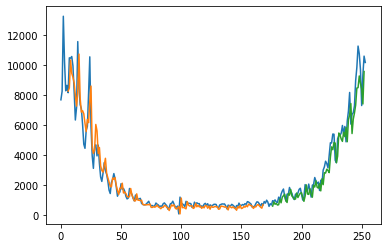

In [285]:
# shift train predictions for plotting
trainPredictPlot = numpy.empty_like(state_cases)
trainPredictPlot[:, :] = numpy.nan
trainPredictPlot[look_back:len(trainPredict)+look_back, :] = trainPredict
# shift test predictions for plotting
testPredictPlot = numpy.empty_like(state_cases)
testPredictPlot[:, :] = numpy.nan
testPredictPlot[len(trainPredict)+(look_back*2)+1:len(state_cases)-1, :] = testPredict
# plot baseline and predictions
plt.plot(scaler.inverse_transform(state_cases))
plt.plot(trainPredictPlot)
plt.plot(testPredictPlot)
plt.show()

## EDA on people wearing masks

In [115]:
masks_data = covidcast.signal("fb-survey", "smoothed_wearing_mask", date(2020, 4, 1), date(2020, 12, 10),"state")

/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_wearing_mask data found on 20200401 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_wearing_mask data found on 20200402 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_wearing_mask data found on 20200403 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_wearing_mask data found on 20200404 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDat

/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_wearing_mask data found on 20200507 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_wearing_mask data found on 20200508 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_wearing_mask data found on 20200509 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_wearing_mask data found on 20200510 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDat

/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_wearing_mask data found on 20200613 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_wearing_mask data found on 20200614 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_wearing_mask data found on 20200615 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_wearing_mask data found on 20200616 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDat

/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_wearing_mask data found on 20200720 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_wearing_mask data found on 20200721 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_wearing_mask data found on 20200722 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_wearing_mask data found on 20200723 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDat

/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_wearing_mask data found on 20200825 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_wearing_mask data found on 20200826 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_wearing_mask data found on 20200827 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_wearing_mask data found on 20200828 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDat

In [65]:
def prepare_data_for_masks(df, state):
    data = df[df['geo_value'] == state]
    data = data[['time_value', 'value']]
    data.dropna()
    data = data.rename(columns={"time_value": "time_value", "value": "masks"})
    data.set_index('time_value', inplace=True)
    return data

<AxesSubplot:xlabel='time_value'>

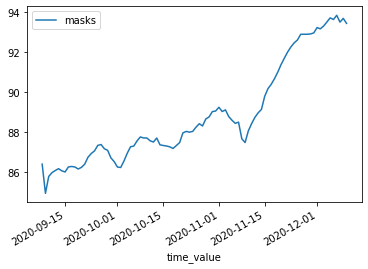

In [66]:
state_cases_df = prepare_data_for_masks(masks_data, 'pa')
state_cases_df.plot()

## EDA on People Travelling outside their state

In [294]:
 smoothed_travel_outside_df = covidcast.signal("fb-survey", "smoothed_travel_outside_state_5d", date(2020, 4, 1), date(2020, 12, 10),"state")

/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_travel_outside_state_5d data found on 20200401 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_travel_outside_state_5d data found on 20200402 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_travel_outside_state_5d data found on 20200403 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_travel_outside_state_5d data found on 20200404 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/sit

In [301]:
def prepare_data_for_travel(df, state):
    data = df[df['geo_value'] == state]
    data = data[['time_value', 'value']]
    data.dropna()
    data = data.rename(columns={"time_value": "time_value", "value": "travelling_outdise"})
    data.set_index('time_value', inplace=True)
    return data

<AxesSubplot:xlabel='time_value'>

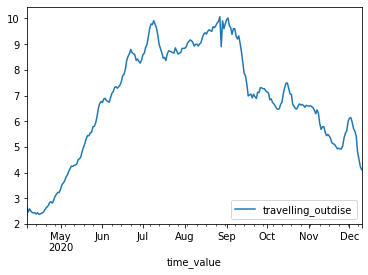

In [302]:
smoothed_travel_outside = prepare_data_for_travel(smoothed_travel_outside_df, 'ny')
smoothed_travel_outside.plot()

## EDA on people going out in restaurants

In [300]:
 smoothed_restaurant_1d = covidcast.signal("fb-survey", "smoothed_restaurant_1d", date(2020, 4, 1), date(2020, 12, 10),"state")

/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_restaurant_1d data found on 20200401 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_restaurant_1d data found on 20200402 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_restaurant_1d data found on 20200403 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_restaurant_1d data found on 20200404 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: N

/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_restaurant_1d data found on 20200508 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_restaurant_1d data found on 20200509 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_restaurant_1d data found on 20200510 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_restaurant_1d data found on 20200511 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: N

/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_restaurant_1d data found on 20200614 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_restaurant_1d data found on 20200615 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_restaurant_1d data found on 20200616 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_restaurant_1d data found on 20200617 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: N

/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_restaurant_1d data found on 20200721 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_restaurant_1d data found on 20200722 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_restaurant_1d data found on 20200723 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_restaurant_1d data found on 20200724 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: N

/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_restaurant_1d data found on 20200826 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_restaurant_1d data found on 20200827 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_restaurant_1d data found on 20200828 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_restaurant_1d data found on 20200829 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: N

In [307]:
def prepare_data_for_restaurant_data(df, state):
    data = df[df['geo_value'] == state]
    data = data[['time_value', 'value']]
    data.dropna()
    data = data.rename(columns={"time_value": "time_value", "value": "restaurants"})
    data.set_index('time_value', inplace=True)
    return data

<AxesSubplot:xlabel='time_value'>

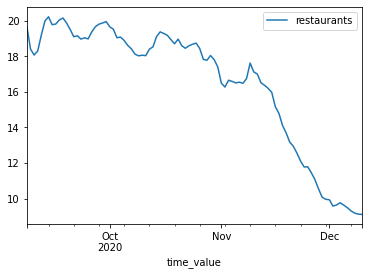

In [308]:
smoothed_restaurant_1d_df = prepare_data_for_restaurant_data(smoothed_restaurant_1d, 'ny')
smoothed_restaurant_1d_df.plot()

## EDA on people spending time with someone else (outside family) 

In [309]:
smoothed_spent_time_1d = covidcast.signal("fb-survey", "smoothed_spent_time_1d", date(2020, 4, 1), date(2020, 12, 10),"state")

/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_spent_time_1d data found on 20200401 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_spent_time_1d data found on 20200402 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_spent_time_1d data found on 20200403 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_spent_time_1d data found on 20200404 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: N

/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_spent_time_1d data found on 20200508 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_spent_time_1d data found on 20200509 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_spent_time_1d data found on 20200510 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_spent_time_1d data found on 20200511 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: N

/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_spent_time_1d data found on 20200613 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_spent_time_1d data found on 20200614 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_spent_time_1d data found on 20200615 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_spent_time_1d data found on 20200616 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: N

/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_spent_time_1d data found on 20200720 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_spent_time_1d data found on 20200721 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_spent_time_1d data found on 20200722 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_spent_time_1d data found on 20200723 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: N

/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_spent_time_1d data found on 20200827 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_spent_time_1d data found on 20200828 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_spent_time_1d data found on 20200829 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: NoDataWarning: No fb-survey smoothed_spent_time_1d data found on 20200830 for geography 'state'
  warnings.warn(f"No {data_source} {signal} data found on {day_str} "
/usr/local/lib/python3.8/site-packages/covidcast/covidcast.py:389: N

In [310]:
def prepare_data_for_meeting_others(df, state):
    data = df[df['geo_value'] == state]
    data = data[['time_value', 'value']]
    data.dropna()
    data = data.rename(columns={"time_value": "time_value", "value": "meeting_others"})
    data.set_index('time_value', inplace=True)
    return data

<AxesSubplot:xlabel='time_value'>

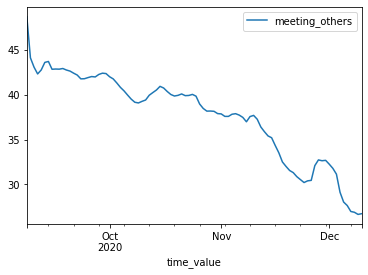

In [312]:
smoothed_spent_time_1d_df = prepare_data_for_meeting_others(smoothed_spent_time_1d, 'ny')
smoothed_spent_time_1d_df.plot()

## Conclusion

As you can see that there is a recent (Nov-Dec) surge in the number of cases, we want to see what are the factors that lead to the increase it the number of cases

1. People started to spend time with non-household members. 
2. People have started going to closed areas like restaurants
3. There is a decrease in the number of people wearing masks
4. People also have started travelling a lot.

All of these have been validated by the data provided by the Covid Delphi API.

## References

1. Neural network powered COVID-19 spread forecasting model - https://www.ncbi.nlm.nih.gov/pmc/articles/PMC7428770/
2. Time Series Prediction with LSTM Recurrent Neural Networks in Python with Keras - https://machinelearningmastery.com/time-series-prediction-lstm-recurrent-neural-networks-python-keras/